# Prediction Model 

Kelun Chai

1. Prophet
2. Arima
3. LSTM

## Data Preperation

In [1]:
import plotly.offline as py
import plotly.express as px
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pred = pd.read_csv("covid-19-all.csv")
pred = pred.fillna(0)
# pred.head()

In [3]:
predgrp = pred[pred['Country/Region']=='France'].groupby('Date')['Confirmed','Recovered','Deaths'].sum().reset_index()
# predgrp.head(7)

In [4]:
pred_cnfrm = predgrp.loc[:,["Date","Confirmed"]]
# pred_cnfrm.head()

In [5]:
pr_data = pred_cnfrm
pr_data.columns = ['ds','y']
# pr_data.head()

## Prophet

In [6]:
m=Prophet()
m.fit(pr_data)
future=m.make_future_dataframe(periods=15)
forecast=m.predict(future)
# forecast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


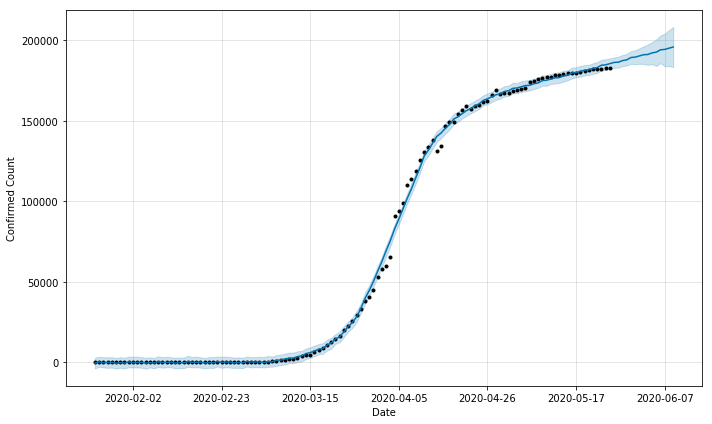

In [7]:
fig = m.plot(forecast,xlabel='Date',ylabel='Confirmed Count')

### Prediction for next 15 days

In [8]:
cnfrm = forecast.loc[:,['ds','trend']]
cnfrm = cnfrm[cnfrm['trend']>0]
cnfrm.columns = ['Date','Confirm']
cnfrm[["Confirm"]] = cnfrm[["Confirm"]].astype(int)
# cnfrm.head()

## Arima

In [9]:
from statsmodels.tsa.arima_model import ARIMA

In [10]:
pred_cnfrm = predgrp.loc[:,["Date","Confirmed"]]

In [11]:
confirm_cs = pred_cnfrm.cumsum()
confirm_cs['date1'] = pred_cnfrm['Date']
confirm_cs = confirm_cs.drop('Date',axis=1)
arima_data = confirm_cs
arima_data.columns = ['count','confirmed_date']
# arima_data.head()

In [12]:
model = ARIMA(arima_data['count'].values, order=(1, 2, 1))
fit_model = model.fit(trend='c', full_output=True, disp=True)
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                  121
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1130.777
Method:                       css-mle   S.D. of innovations           2762.369
Date:                Wed, 27 May 2020   AIC                           2269.554
Time:                        06:24:22   BIC                           2280.738
Sample:                             2   HQIC                          2274.096
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1218.4058   1051.330      1.159      0.246    -842.163    3278.975
ar.L1.D2.y     0.9537      0.032     29.916      0.000       0.891       1.016
ma.L1.D2.y    -0.7844      0.058    -13.582      0.000      -0.898      -0.671
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0485           +0.0000j            1.0485            0.0000
MA.1            1.2749           +0.0000j            1.2749            0.0000
-----------------------------------------------------------------------------
"""

In [13]:
forcast = fit_model.forecast(steps=7)
pred_y = forcast[0].tolist()
pred = pd.DataFrame(pred_y)
pred['pred']=  pred - pred.shift(1) 
pred

,0,pred
0,9.013058e+06,NaN
1,9.197288e+06,184230.001726
2,9.382144e+06,184855.384282
3,9.567652e+06,185508.222595
4,9.753839e+06,186187.245520
5,9.940731e+06,186891.240763
6,1.012835e+07,187619.052156


In [14]:
dataset_c = pd.DataFrame(pred_cnfrm['Confirmed'])
# dataset_c.tail()

In [15]:
data = np.array(dataset_c).reshape(-1, 1)
train_data = dataset_c[:len(dataset_c)-8]
test_data = dataset_c[len(dataset_c)-8:]

## LSTM

In [16]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [17]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)
n_input =5
n_features =1
                             
generator = TimeseriesGenerator(scaled_train_data,scaled_train_data, length=n_input, batch_size=1)

lstm_model = Sequential()
lstm_model.add(LSTM(units = 50, return_sequences = True, input_shape = (n_input, n_features)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50, return_sequences = True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units = 1))
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
lstm_model.fit(generator, epochs = 8)

Epoch 1/8
110/110 [==============================] - 1s 9ms/step - loss: 0.0566
Epoch 2/8
110/110 [==============================] - 1s 7ms/step - loss: 0.0092
Epoch 3/8
110/110 [==============================] - 1s 7ms/step - loss: 0.0089
Epoch 4/8
110/110 [==============================] - 1s 7ms/step - loss: 0.0067
Epoch 5/8
110/110 [==============================] - 1s 7ms/step - loss: 0.0055
Epoch 6/8
110/110 [==============================] - 1s 7ms/step - loss: 0.0050
Epoch 7/8
110/110 [==============================] - 1s 7ms/step - loss: 0.0044
Epoch 8/8
110/110 [==============================] - 1s 7ms/step - loss: 0.0060


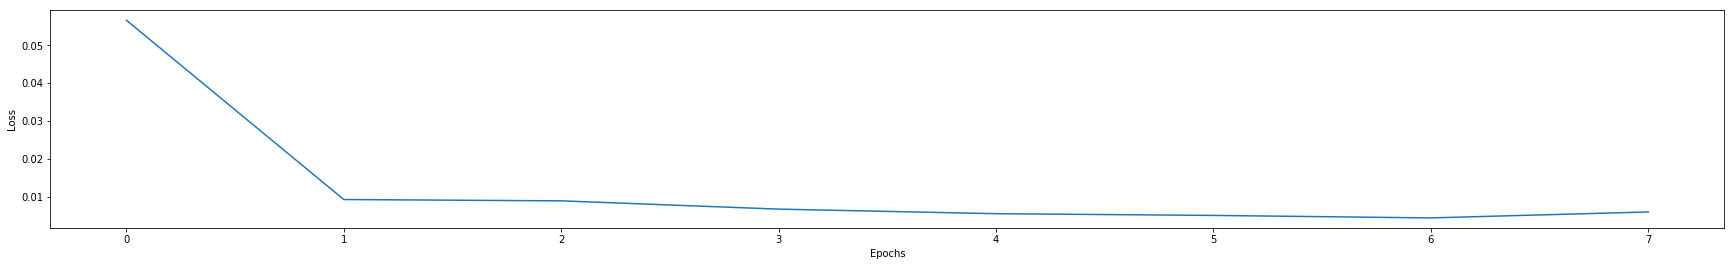

In [18]:
import matplotlib.pyplot as plt
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize = (30,4))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(0,100,1))
plt.plot(range(len(losses_lstm)), losses_lstm)
plt.show()

In [19]:
lstm_predictions_scaled = []

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

prediction = pd.DataFrame(scaler.inverse_transform(lstm_predictions_scaled))
prediction

,0
0,170233.708570
1,170369.430990
2,170133.426924
3,169376.189645
4,168068.501132
5,166014.157234
6,165861.373118
7,165498.664804


## Fit with sigmoid

In [20]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Any results you write to the current directory are saved as output.
train=pd.read_csv('covid-19-all.csv')
train.fillna(0)
train.head(10)

,Country/Region,Province/State,Latitude,Longitude,Confirmed,Recovered,Deaths,Date
0,China,Anhui,31.8257,117.2264,1.0,NaN,NaN,2020-01-22
1,China,Beijing,40.1824,116.4142,14.0,NaN,NaN,2020-01-22
2,China,Chongqing,30.0572,107.8740,6.0,NaN,NaN,2020-01-22
3,China,Fujian,26.0789,117.9874,1.0,NaN,NaN,2020-01-22
4,China,Gansu,37.8099,101.0583,NaN,NaN,NaN,2020-01-22
5,China,Guangdong,23.3417,113.4244,26.0,NaN,NaN,2020-01-22
6,China,Guangxi,23.8298,108.7881,2.0,NaN,NaN,2020-01-22
7,China,Guizhou,26.8154,106.8748,1.0,NaN,NaN,2020-01-22
8,China,Hainan,19.1959,109.7453,4.0,NaN,NaN,2020-01-22
9,China,Hebei,39.5490,116.1306,1.0,NaN,NaN,2020-01-22


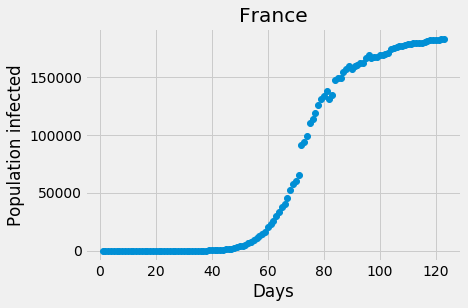

In [21]:
country_df = train[train['Country/Region']=='France'].groupby('Date')['Confirmed','Deaths'].sum()
country_df['day_count'] = list(range(1,len(country_df)+1))
ydata = country_df.Confirmed
xdata = country_df.day_count
country_df['rate'] = (country_df.Confirmed-country_df.Confirmed.shift(1))/country_df.Confirmed
country_df['increase'] = (country_df.Confirmed-country_df.Confirmed.shift(1))

plt.plot(xdata, ydata, 'o')
plt.title("France")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

[92.63362386  1.75222064  4.22892906]


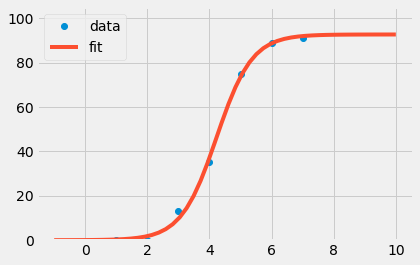

In [22]:
from scipy.optimize import curve_fit
import pylab


def sigmoid(x,c,a,b):
     y = c*1 / (1 + np.exp(-a*(x-b)))
     return y
#country_df.ConfirmedCases
#country_df.day_count
xdata = np.array([1, 2, 3,4, 5, 6, 7])
ydata = np.array([0, 0, 13, 35, 75, 89, 91])

#([low_a,low_b],[high_a,high_b])
#low x --> low b
#high y --> high c
#a is the sigmoidal shape.
popt, pcov = curve_fit(sigmoid, xdata, ydata, method='dogbox',bounds=([0.,0., 0.],[100,2, 10.]))
print(popt)

x = np.linspace(-1, 10, 50)
y = sigmoid(x, *popt)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(x,y, label='fit')
pylab.ylim(-0.05, 105)
pylab.legend(loc='best')
pylab.show()

In [23]:
in_df = train[train['Country/Region']=='France'].groupby('Date')['Confirmed','Deaths','Recovered'].sum().reset_index(False)
in_df['Active']=in_df['Confirmed']-in_df['Deaths']-in_df['Recovered']
in_df = in_df[in_df.Active>=100]

In [24]:
import pylab
from datetime import timedelta

in_df['day_count'] = list(range(1,len(in_df)+1))
in_df['increase'] = (in_df.Active-in_df.Active.shift(1))
in_df['rate'] = (in_df.Active-in_df.Active.shift(1))/in_df.Active


def sigmoid(x,c,a,b):
     y = c*1 / (1 + np.exp(-a*(x-b)))
     return y

xdata = np.array(list(in_df.day_count)[::2])
ydata = np.array(list(in_df.Active)[::2])

population=1.332*10**9
popt, pcov = curve_fit(sigmoid, xdata, ydata, method='dogbox',bounds=([0.,0., 0.],[population,6, 100.]))
print(popt)

[9.39416648e+04 2.15689871e-01 3.16315125e+01]


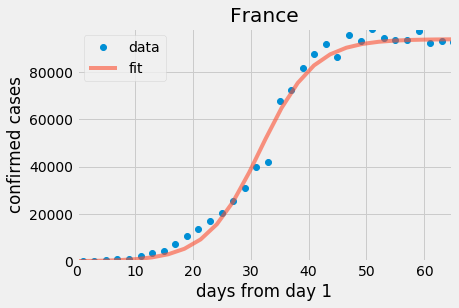

model fitted max Active at: 93941
model sigmoidal coefficient is: 0.216
model curve stop steepening, start flattening by day: 31
model curve flattens by day: 62


,Date,Confirmed,Deaths,Recovered,Active,day_count,increase,rate
37,2020-03-01,130.0,2.0,12.0,116.0,1,NaN,NaN
38,2020-03-02,191.0,3.0,12.0,176.0,2,60.0,0.340909
39,2020-03-03,204.0,4.0,12.0,188.0,3,12.0,0.063830


,Date,Confirmed,Deaths,Recovered,Active,day_count,increase,rate
120,2020-05-23,182036.0,28218.0,63988.0,89830.0,84,19.0,0.000212
121,2020-05-24,182709.0,28370.0,64735.0,89604.0,85,-226.0,-0.002522
122,2020-05-25,183067.0,28460.0,65317.0,89290.0,86,-314.0,-0.003517


In [25]:
est_a = popt[0]
est_b = popt[1]
est_c = popt[2]
x = np.linspace(-1, in_df.day_count.max()+50, 50)
y = sigmoid(x,est_a,est_b,est_c)
pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(x,y, label='fit',alpha = 0.6)
pylab.ylim(-0.05, est_a*1.05)
pylab.xlim(-0.05, est_c*2.05)
pylab.legend(loc='best')
plt.xlabel('days from day 1')
plt.ylabel('confirmed cases')
plt.title('France')
pylab.show()


#print('model start date:',in_df[in_df.day_count==1].index[0])
#print('model start infection:',int(in_df[in_df.day_count==1].Active[0]))
print('model fitted max Active at:',int(est_a))
print('model sigmoidal coefficient is:',round(est_b,3))
print('model curve stop steepening, start flattening by day:',int(est_c))
print('model curve flattens by day:',int(est_c)*2)
display(in_df.head(3))
display(in_df.tail(3))